## 28-8. 프로젝트 : 개구리는 안돼요(CIFAR-10)

* 이번 프로젝트는 CIFAR-10 데이터셋에 대해 진행
* 만들어야 할 모델은 CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델
* 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경고를 발생시키는 개구리 감지 모델

다음의 순서을 따라 진행해 주세요.

1. 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
2. Skip-GANomaly 모델의 구현
3. 모델의 학습과 검증
4. 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계산, 감지 성공/실패사례 시각화 포함)

In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np


import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

 * cifar10 data 불러오기

In [41]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

# padding to 32 X 32
train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
# train_data_32[:, 2:30, 2:30] = train_data
# test_data_32[:, 2:30, 2:30] = test_data

# # 1channel data reshape
# train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 3).astype('float32')
# test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 3).astype('float32')

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

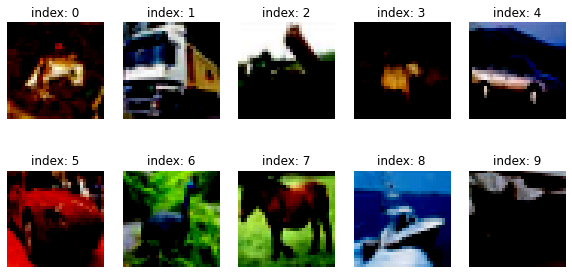

In [47]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
#     plt.imshow(train_data[i].reshape(32, 32), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [49]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # frog:6
            new_t_labels.append([0])  # Bag을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [50]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [51]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [52]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [53]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [54]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [55]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [56]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [57]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator 모델 구성

 * Generator는 U-net 구조를 따름


In [60]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [61]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [62]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator 구성

 * Discriminator도 Generator처럼 Conv_block을 활용
 * 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴

In [63]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

### 전체 모델 구성

 * Generator와 Discriminator을 합쳐 전체 모델을 구성

In [72]:
generator = Generator()  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

### Loss 함수

 * GAN 모델의 핵심은 Loss 함수의 구성방법임
 * Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행

In [73]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [74]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

 * 아래 Generator Loss에는 이전 스텝에서 설명했던 Skip-GANomaly의 주요 loss 함수들이 포함되어 있음을 주목

In [75]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [76]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## 모델 학습과 평가

### Model Train

 * 모델 학습(총 25Epoch 대략 1시간 정도 소요)

In [77]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [78]:
import os
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [80]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 20.564992904663086, 	 Total Dis Loss : 0.0657399371266365
Steps : 200, 	 Total Gen Loss : 19.48797035217285, 	 Total Dis Loss : 0.07077478617429733
Steps : 300, 	 Total Gen Loss : 17.96833038330078, 	 Total Dis Loss : 0.029569678008556366
Steps : 400, 	 Total Gen Loss : 18.0872745513916, 	 Total Dis Loss : 0.10709141194820404
Steps : 500, 	 Total Gen Loss : 18.820566177368164, 	 Total Dis Loss : 0.050186291337013245
Steps : 600, 	 Total Gen Loss : 16.895036697387695, 	 Total Dis Loss : 0.05767148733139038
Steps : 700, 	 Total Gen Loss : 17.987316131591797, 	 Total Dis Loss : 0.019682899117469788
Steps : 800, 	 Total Gen Loss : 21.32130241394043, 	 Total Dis Loss : 0.00723644532263279
Steps : 900, 	 Total Gen Loss : 21.35956382751465, 	 Total Dis Loss : 0.04263981804251671
Steps : 1000, 	 Total Gen Loss : 20.344135284423828, 	 Total Dis Loss : 0.009212363511323929
Steps : 1100, 	 Total Gen Loss : 22.68040657043457, 	 Total Dis Loss : 0.00827875453978777
S

Steps : 9000, 	 Total Gen Loss : 22.24791717529297, 	 Total Dis Loss : 0.0009502823813818395
Steps : 9100, 	 Total Gen Loss : 22.989059448242188, 	 Total Dis Loss : 0.006876026280224323
Steps : 9200, 	 Total Gen Loss : 20.594064712524414, 	 Total Dis Loss : 0.0023791957646608353
Steps : 9300, 	 Total Gen Loss : 23.47322654724121, 	 Total Dis Loss : 0.004483907483518124
Steps : 9400, 	 Total Gen Loss : 23.7493953704834, 	 Total Dis Loss : 0.007385968696326017
Steps : 9500, 	 Total Gen Loss : 20.801794052124023, 	 Total Dis Loss : 0.0018227086402475834
Steps : 9600, 	 Total Gen Loss : 19.941381454467773, 	 Total Dis Loss : 0.0023810085840523243
Steps : 9700, 	 Total Gen Loss : 19.82233428955078, 	 Total Dis Loss : 0.0019157397327944636
Steps : 9800, 	 Total Gen Loss : 20.534713745117188, 	 Total Dis Loss : 0.00527633260935545
Steps : 9900, 	 Total Gen Loss : 24.230140686035156, 	 Total Dis Loss : 0.0012544840574264526
Steps : 10000, 	 Total Gen Loss : 21.464881896972656, 	 Total Dis Loss

Steps : 17700, 	 Total Gen Loss : 24.63616180419922, 	 Total Dis Loss : 0.0013797483406960964
Steps : 17800, 	 Total Gen Loss : 22.77141571044922, 	 Total Dis Loss : 0.0012469749199226499
Steps : 17900, 	 Total Gen Loss : 23.44056510925293, 	 Total Dis Loss : 0.0012601364869624376
Steps : 18000, 	 Total Gen Loss : 25.036584854125977, 	 Total Dis Loss : 0.00022416969295591116
Steps : 18100, 	 Total Gen Loss : 22.666587829589844, 	 Total Dis Loss : 0.0005528422771021724
Steps : 18200, 	 Total Gen Loss : 24.222370147705078, 	 Total Dis Loss : 0.000584521098062396
Steps : 18300, 	 Total Gen Loss : 24.70542335510254, 	 Total Dis Loss : 0.0006694335024803877
Steps : 18400, 	 Total Gen Loss : 25.41066551208496, 	 Total Dis Loss : 0.0003224338870495558
Steps : 18500, 	 Total Gen Loss : 25.034574508666992, 	 Total Dis Loss : 0.0010606974828988314
Steps : 18600, 	 Total Gen Loss : 23.37576675415039, 	 Total Dis Loss : 0.000211805003345944
Steps : 18700, 	 Total Gen Loss : 21.18553924560547, 	 To

Steps : 26400, 	 Total Gen Loss : 26.870819091796875, 	 Total Dis Loss : 0.00015712552703917027
Steps : 26500, 	 Total Gen Loss : 23.715002059936523, 	 Total Dis Loss : 0.00041427236283198
Steps : 26600, 	 Total Gen Loss : 25.96163558959961, 	 Total Dis Loss : 0.0004280090215615928
Steps : 26700, 	 Total Gen Loss : 24.18981170654297, 	 Total Dis Loss : 0.0010532104643061757
Steps : 26800, 	 Total Gen Loss : 26.270965576171875, 	 Total Dis Loss : 0.00023123652499634773
Steps : 26900, 	 Total Gen Loss : 24.298980712890625, 	 Total Dis Loss : 0.00041509734001010656
Steps : 27000, 	 Total Gen Loss : 23.91424560546875, 	 Total Dis Loss : 0.00022978364722803235
Steps : 27100, 	 Total Gen Loss : 29.056568145751953, 	 Total Dis Loss : 0.00013229696196503937
Steps : 27200, 	 Total Gen Loss : 21.315608978271484, 	 Total Dis Loss : 0.0016825663624331355
Steps : 27300, 	 Total Gen Loss : 23.703983306884766, 	 Total Dis Loss : 0.0002876531798392534
Steps : 27400, 	 Total Gen Loss : 22.4637241363525

NameError: name 'checkpoint_prefix' is not defined

### Model Evaluation

 * 학습 도중 저장된 Checkpoint를 아래와 같이 활용할 수 있음

In [81]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [82]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [83]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


 * 아래와 같이 테스트 결과를 원래 라벨에 따라 anomaly 데이터와 normal 데이터로 나누어 따로 분석
 * 라벨에 따라 anomaly score의 분포가 다르게 나타나는지를 검증

In [84]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


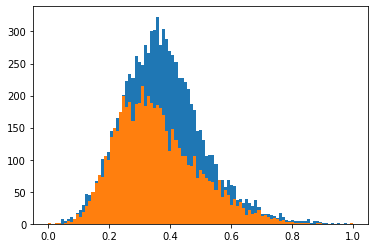

In [85]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3768786 0.35720283
0.13266867 0.1343133


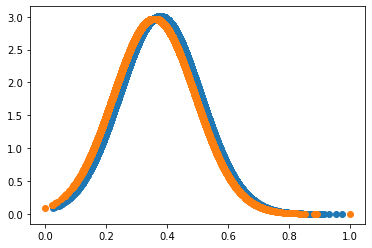

In [86]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))